In [49]:
path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Imagenes_confocal/Rata/C071112/'
nombre_foto = 'c3ack009'
x_calibracion = 4.5

import numpy as np                # funciones numéricas (arrays, matrices, etc.)
import matplotlib.pyplot as plt   # funciones para representación gráfica
%matplotlib inline
import cv2
from PIL import Image
import pandas as pd
import  csv
#     '''This function finds a tList in sec yList - measurements ySS - the steady state value of y returns amplitude of exponent tau - the time constant'''
from math import log
from pylab import lstsq
from pylab import matrix
from pylab import exp


def fitExponent(tList,yList,ySS=0):
    bList = [log(max(y-ySS,1e-6)) for y in yList]
    (w,residuals,rank,sing_vals) = lstsq(matrix([[1,t] for t in tList]),matrix(bList).T)
    tau = -1.0/w[1,0]
    amplitude = exp(w[0,0])
    return (amplitude,tau)

In [50]:
def select_roi (image):
    import cv2
    fromCenter = False
    showCrosshair = False
    r = cv2.selectROI(image, fromCenter, showCrosshair)
    return r

def crop_image (image, r):
    imCrop = image[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
    return imCrop

def display_image (name , image):
    cv2.imshow(name, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def f(brightness, contrast):
    img = np.int16(imCrop)
    img = img * (contrast/127+1) - contrast + brightness
    img = np.clip(img, 0, 255)
    img = np.uint8(img)
    plt.imshow(img)
    plt.show()
    return img

def rotation (image_path, degrees):
    import numpy
    from PIL import Image
    import cv2
    im = Image.fromarray(image_path)
    im = im.rotate(degrees)
    im = numpy.array(im)
    
def filtration (image):
    import cv2
    original = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 50)
    canny = cv2.Canny(blurred, 100, 250, 400)
    kernel = np.ones((5,5),np.uint8)
    dilate = cv2.dilate(canny, kernel, iterations=1)
    return dilate, original

def find_contourns (image):
    import cv2
    cnts = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    return cnts

def plot_histogram (y_data, nombre_foto, label_x, label_y):
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.plot(y_data)
    plt.title(nombre_foto)
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.show()

def track_contours (c, image, track_number):
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(auto_result, (x, y), (x + w, y + h), (255,255,0), 2)
    cv2.putText(auto_result, str(track_number), (x-2, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,0),2)
    ROI = original[y:y+h, x:x+w]
    x_data = np.asarray(range(x,x+w),dtype=np.float64)
    #análisis de cada spark
    SI = Image.fromarray(ROI.astype(np.uint8))
    img_col_mean = np.mean(SI,axis=0) #lista de datos del histograma por columna
    img_row_mean = np.mean(SI,axis=1) #lista de datos del histograma por fila
    img_col_mean = [x.mean() for x in img_col_mean]
    img_row_mean = [x.mean() for x in img_row_mean]
    return img_row_mean , img_col_mean

In [51]:
if __name__ == '__main__' :

    imag = cv2.imread(path + nombre_foto + ".tif")    # Read image

    if imag is None:
        print("Check file path")
    else:
        r = select_roi (imag) # Select ROI
        imCrop = crop_image (imag, r)    # Crop image
        display_image ('Image' , imCrop)    # Display cropped image

In [33]:
from __future__ import print_function
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

img_bc = interactive(f, brightness=100, contrast=100)   #display brightness and contrast
display (img_bc)

interactive(children=(IntSlider(value=100, description='brightness', max=300, min=-100), IntSlider(value=100, …

In [33]:
im = rotation (imCrop, 90)    # rotate image
display_image ('Image' , im)    # Display cropped image

error: OpenCV(4.1.2) C:\projects\opencv-python\opencv\modules\highgui\src\window.cpp:376: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


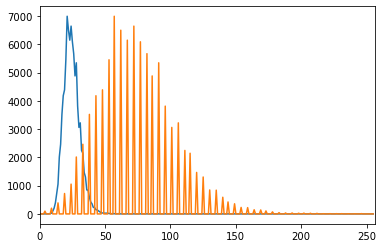

alpha 4.811320754716981
beta -43.30188679245283


In [66]:
import cv2
import numpy as np
# from matplotlib import pyplot as plt

# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(image, clip_hist_percent=10):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 750

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    
    # Calculate new histogram with desired range and show histogram
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)

image = cv2.imread(path + nombre_foto + ".tif")
auto_result, alpha, beta = automatic_brightness_and_contrast(imCrop)
print('alpha', alpha)
print('beta', beta)
cv2.imshow('auto_result', auto_result)
# cv2.imwrite('auto_result.png', auto_result)
cv2.imshow('image', imCrop)
cv2.waitKey()
cv2.destroyAllWindows()

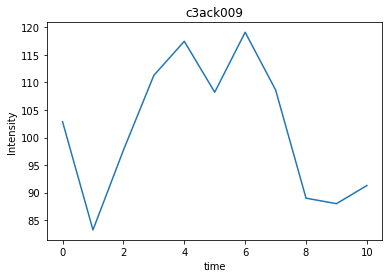

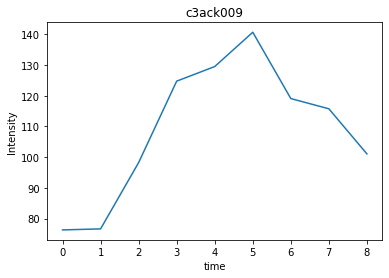

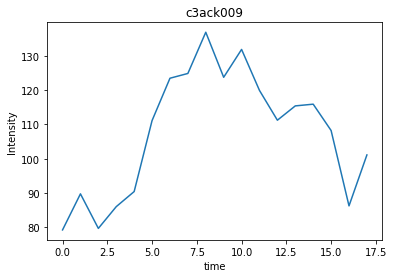

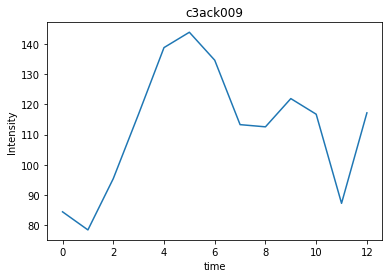

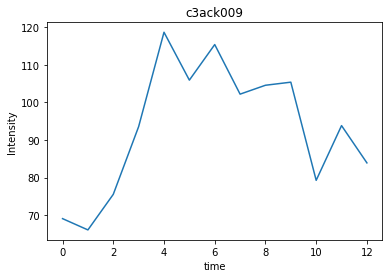

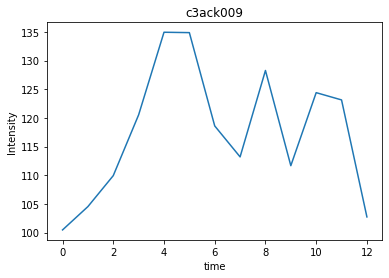

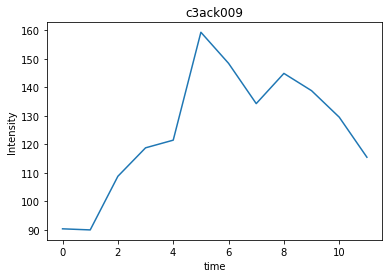

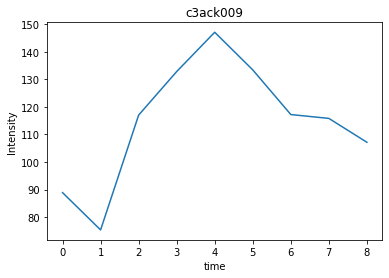

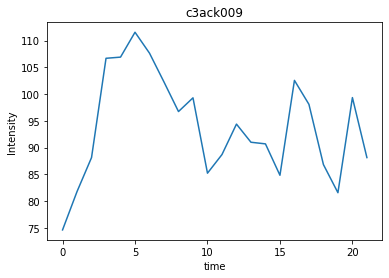

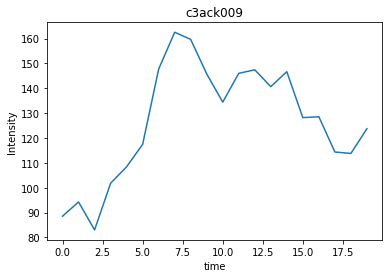

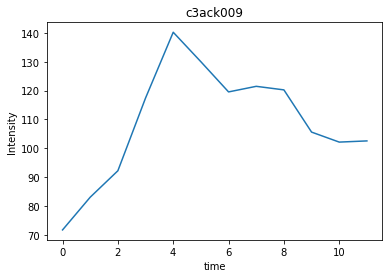

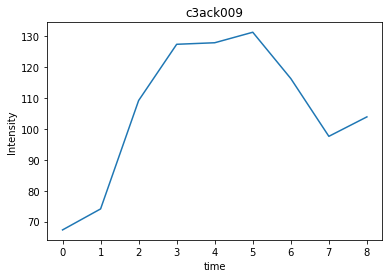

In [67]:
dilate = filtration (auto_result)[0]
original = filtration (auto_result)[1]

cnts = find_contourns (dilate)    # Find contours

# Iterate thorugh contours and filter for ROI
list_img_col = []
track_number = 0
for c in cnts:
    img_col_mean = track_contours (c, auto_result, track_number) [0]
    track_number +=1
    list_img_col.append (img_col_mean)
    plot_histogram (img_col_mean, nombre_foto, "time", "Intensity")    #gráfico de histograma

#     cv2.imwrite("ROI_{}.png".format(track_number), ROI)
#     track_number += 1

display_image ('image' , auto_result)

## **Aplicación de análisis sobre picos** 

In [54]:
def maximo_peak (vector):
    import numpy as np
    from peakutils.peak import indexes
    import peakutils
    indexes = indexes(np.array(vector), thres=1.0/max(vector), min_dist=10)
    kk = list(indexes)
    for j in kk:
        if vector[j]> (sum(vector) / len(vector)):
            tiempos = j
            intensidades = vector[j]
    return tiempos,intensidades

cantidad_sparks = len(list_img_col)

datos_tiempos = {}
datos_intensidades = {}

for i in range (0,cantidad_sparks):
    picos = maximo_peak (list_img_col[i])
    datos_tiempos [i] = picos [0]
    datos_intensidades [i] = picos [1]
    

Columns = ['Spark_'+ str(x) for x in range(0, cantidad_sparks)]
out_sparks = pd.DataFrame([datos_tiempos.values(),datos_intensidades.values()], columns = Columns).T
out_sparks = pd.DataFrame(out_sparks.values, columns = ['tiempo_maximo', 'intensidad_maxima'])

In [55]:
#  Detección de mínimos locales
# Calculate the n-th discrete difference along the given axis. The first difference is given by out[i] = a[i+1] - a[i] along the given axis, higher differences are calculated by using diff recursively.
# The sign function returns -1 if x < 0, 0 if x==0, 1 if x > 0. nan is returned for nan inputs.

def minimo_bl (vector):
    data = np.asarray(vector,dtype=np.int)
    b = (np.diff(np.sign(np.diff(data))) > 0).nonzero()[0] + 1
    return b

# Esta celda calcula los mínimos de la selección de toda la célula tomando los mínimos calculados, quedandose con el más chico entre dos máximos.
# Devuelve el valor de tiempos y las intensidades en dataframes por separado.

sparks_tiempo0 = []
sparks_intensidad0 = []        
sparks_tiempo_n = []
sparks_intensidad_n = []

for i in range (0,cantidad_sparks):
    picos = minimo_bl (list_img_col[i])
    lista_min = []
    for minimo in picos:
        picomenor = int(out_sparks['tiempo_maximo'][i])
        if minimo < picomenor:
            y_min = list_img_col[i] [minimo]
            lista_min.append((minimo,y_min))
    try:
        minimo_lista_mins = min(lista_min, key = lambda t: t[1])
        sparks_tiempo0.append(minimo_lista_mins[0])
        sparks_intensidad0.append (minimo_lista_mins[1])
    except ValueError:
        minimo_lista_mins = min (list_img_col[i][0:int(out_sparks['tiempo_maximo'][i])])
        minimimo = list_img_col[i].index(minimo_lista_mins)
        sparks_tiempo0.append(minimimo)
        sparks_intensidad0.append (minimo_lista_mins)

out_sparks['tiempo_minimo'] = sparks_tiempo0
out_sparks['intensidad_minima'] = sparks_intensidad0

# final minimun

for i in range (0,cantidad_sparks):
    picos = minimo_bl (list_img_col[i])
    lista_min = []
    for minimo in picos:
        picomenor = int(out_sparks['tiempo_maximo'][i])
        if minimo > picomenor:
            y_min = list_img_col[i] [minimo]
            lista_min.append((minimo,y_min))
    try:
        minimo_lista_mins = min(lista_min, key = lambda t: t[1])
        sparks_tiempo_n.append(minimo_lista_mins[0])
        sparks_intensidad_n.append (minimo_lista_mins[1])
    except ValueError:
        minimo_lista_mins = min (list_img_col[i][int(out_sparks['tiempo_maximo'][i]):len (list_img_row[i])])
        minimimo = list_img_col[i].index(minimo_lista_mins)
        sparks_tiempo_n.append(minimimo)
        sparks_intensidad_n.append (minimo_lista_mins)

out_sparks['tiempo_valle'] = sparks_tiempo_n
out_sparks['intensidad_valle'] = sparks_intensidad_n

In [56]:
# Calcula la amplitud de cada pico como la diferencia entre la intensidad máximo y mínimo 

sparks_amplitud = []
for sp in range(0, cantidad_sparks):
    sp_amplitud = (out_sparks['intensidad_maxima'] [sp] - out_sparks['intensidad_minima'] [sp])/out_sparks['intensidad_minima'] [sp]
    sparks_amplitud.append(sp_amplitud)
out_sparks['amplitud'] = sparks_amplitud

In [57]:
# Cálculo del tiempo al pico como la diferencia en el tiempo máximo y mínimo para toda la selección

sparks_tiempo_al_pico = []
for sp in range  (0, cantidad_sparks):
    sp_ttp = out_sparks['tiempo_maximo'] [sp] - out_sparks['tiempo_minimo'] [sp]
    sparks_tiempo_al_pico.append(sp_ttp)
out_sparks['TTP'] = sparks_tiempo_al_pico

In [58]:
import scipy.stats

# Calcula el tiempo al 50% del pico de cada pico de la selección

sparks_tiempo_pico50 = []

for sp in range  (0, cantidad_sparks):
    sp_amp50 = (out_sparks['intensidad_maxima'] [sp] + out_sparks['intensidad_minima'] [sp])/2   
    x1 = np.asarray (range (int(out_sparks['tiempo_minimo'] [sp]), int(out_sparks['tiempo_maximo'] [sp]+1))) 
    y1 = np.asarray (list_img_col [sp] [int(out_sparks['tiempo_minimo'] [sp]) : int(out_sparks['tiempo_maximo'] [sp]+1)])
    ySS = 0
    (amplitudeEst,tauEst) = fitExponent(x1,y1,ySS)
    yEst = amplitudeEst*(exp(-x1/tauEst))+ySS
    sp_ttp50 = (np.log((sp_amp50 -ySS)/ amplitudeEst))*(-tauEst)
    sparks_tiempo_pico50.append (sp_ttp50)
out_sparks['TTP50'] = sparks_tiempo_pico50 - out_sparks['tiempo_minimo']

# Calculo del FDHM
sparks_tiempo_pico50_2 = []
for sp in range  (0, cantidad_sparks):
    sp_amp50 = (out_sparks['intensidad_maxima'] [sp] + out_sparks['intensidad_minima'] [sp])/2
    x2 = np.asarray (range (int(out_sparks['tiempo_maximo'] [sp]), int(out_sparks['tiempo_valle'] [sp]+1))) 
    y2 = np.asarray (list_img_col [sp] [int(out_sparks['tiempo_maximo'] [sp]) : int(out_sparks['tiempo_valle'] [sp]+1)])
    (amplitudeEst2,tauEst2) = fitExponent(x2,y2,ySS)  
    yEst2 = amplitudeEst2*(exp(-x2/tauEst2))+ySS
    sp_ttp50_2 = (np.log((sp_amp50 -ySS)/ amplitudeEst2))*(-tauEst2)
    sparks_tiempo_pico50_2.append (sp_ttp50_2)
out_sparks['FDHM'] =[A - B for (A, B) in zip(sparks_tiempo_pico50_2, sparks_tiempo_pico50)]

C:\Users\Leand\PyMOL\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [59]:
#     '''This function finds a tList in sec yList - measurements ySS - the steady state value of y returns amplitude of exponent tau - the time constant'''
from math import log
from pylab import lstsq
from pylab import matrix
from pylab import exp

def fitExponent(tList,yList,ySS=0):
    bList = [log(max(y-ySS,1e-6)) for y in yList]
    (w,residuals,rank,sing_vals) = lstsq(matrix([[1,t] for t in tList]),matrix(bList).T)
    tau = -1.0/w[1,0]
    amplitude = exp(w[0,0])
    return (amplitude,tau)

# Aplico la función para tau a la selección

sp_tau = []
for sp in range (0, cantidad_sparks):
    x = np.asarray(list (range(int(out_sparks['tiempo_maximo'] [sp]), int(out_sparks['tiempo_valle'] [sp])+1))) #* x_calibracion
    y = np.asarray(list_img_col[sp][int(out_sparks['tiempo_maximo'] [sp]) : int(out_sparks['tiempo_valle'] [sp])+1],dtype=np.float64)
    ySS = 0
    (amplitudeEst,tauEst) = fitExponent(x,y,ySS)
    yEst = amplitudeEst*(exp(-x/tauEst))+ySS
    sp_tau.append (tauEst)
#     plt.figure(1)
#     plt.plot(x,y,'+r',markersize=6,markeredgewidth=2)
#     plt.plot(x,yEst,'--g')
#     plt.xlabel('seconds')
#     plt.legend(['Measured values','Estimated value'])
#     plt.grid(True)
#     plt.show()

out_sparks['tau'] = sp_tau

C:\Users\Leand\PyMOL\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


In [60]:
##  Calculo de (ΔF/F0)/ΔTmax

out_sparks['(ΔF/F0)/ΔTmax'] = out_sparks['amplitud']/out_sparks['TTP']

##  Calculo fullDuration

out_sparks['fullDuration'] = out_sparks['tiempo_valle'] - out_sparks['tiempo_minimo']

In [69]:
# Iterate thorugh contours and filter for ROI para el ancho de pico
list_img_row = []
track_number = 0
for c in cnts:
    img_row_mean = track_contours (c, auto_result, track_number) [1]
    track_number +=1
    list_img_row.append (img_row_mean)

display_image ('image' , auto_result)

def maximo_peak (vector):
    import numpy as np
    from peakutils.peak import indexes
    import peakutils
    indexes = indexes(np.array(vector), thres=1.0/max(vector), min_dist=10)
    kk = list(indexes)
    for j in kk:
        if vector[j]> (sum(vector) / len(vector)):
            tiempos = j
            intensidades = vector[j]
    return tiempos,intensidades

cantidad_sparks = len(list_img_row)

datos_tiempos = {}
datos_intensidades = {}

for i in range (0,cantidad_sparks):
    picos = maximo_peak (list_img_row[i])
    datos_tiempos [i] = picos [0]
    datos_intensidades [i] = picos [1]
    

Columns = ['Spark_'+ str(x) for x in range(0, cantidad_sparks)]
out_sparks_row = pd.DataFrame([datos_tiempos.values(),datos_intensidades.values()], columns = Columns).T
out_sparks_row = pd.DataFrame(out_sparks_row.values, columns = ['tiempo_maximo', 'intensidad_maxima'])

# Esta celda calcula los mínimos de la selección de toda la célula tomando los mínimos calculados, quedandose con el más chico entre dos máximos.
# Devuelve el valor de tiempos y las intensidades en dataframes por separado.

sparks_tiempo0 = []
sparks_intensidad0 = []        
sparks_tiempo_n = []
sparks_intensidad_n = []

for i in range (0,cantidad_sparks):
    picos = minimo_bl (list_img_row[i])
    lista_min = []
    for minimo in picos:
        picomenor = int(out_sparks_row['tiempo_maximo'][i])
        if minimo < picomenor:
            y_min = list_img_row[i] [minimo]
            lista_min.append((minimo,y_min))
    try:
        minimo_lista_mins = min(lista_min, key = lambda t: t[1])
        sparks_tiempo0.append(minimo_lista_mins[0])
        sparks_intensidad0.append (minimo_lista_mins[1])
    except ValueError:
        minimo_lista_mins = min (list_img_row[i][0:int(out_sparks['tiempo_maximo'][i])])
        minimimo = list_img_row[i].index(minimo_lista_mins)
        sparks_tiempo0.append(minimimo)
        sparks_intensidad0.append (minimo_lista_mins)

out_sparks_row['tiempo_minimo'] = sparks_tiempo0
out_sparks_row['intensidad_minima'] = sparks_intensidad0

# final minimun

for i in range (0,cantidad_sparks):
    picos = minimo_bl (list_img_row[i])
    lista_min = []
    for minimo in picos:
        picomenor = int(out_sparks['tiempo_maximo'][i])
        if minimo > picomenor:
            y_min = list_img_row[i] [minimo]
            lista_min.append((minimo,y_min))
    try:
        minimo_lista_mins = min(lista_min, key = lambda t: t[1])
        sparks_tiempo_n.append(minimo_lista_mins[0])
        sparks_intensidad_n.append (minimo_lista_mins[1])
    except ValueError:
        minimo_lista_mins = min (list_img_row[i][int(out_sparks['tiempo_maximo'][i]):len (list_img_row[i])])
        minimimo = list_img_row[i].index(minimo_lista_mins)
        sparks_tiempo_n.append(minimimo)
        sparks_intensidad_n.append (minimo_lista_mins)

out_sparks_row['tiempo_valle'] = sparks_tiempo_n
out_sparks_row['intensidad_valle'] = sparks_intensidad_n

In [72]:
##  Calculo fullWidth

out_sparks['fullWidth'] = out_sparks_row['tiempo_valle'] - out_sparks_row['tiempo_minimo']

In [74]:
import scipy.stats

# Calculo del FWHM

sparks_tiempo_pico50 = []

for sp in range  (0, cantidad_sparks):
    sp_amp50 = (out_sparks_row['intensidad_maxima'] [sp] + out_sparks_row['intensidad_minima'] [sp])/2   
    x1 = np.asarray (range (int(out_sparks_row['tiempo_minimo'] [sp]), int(out_sparks_row['tiempo_maximo'] [sp]+1))) 
    y1 = np.asarray (list_img_row [sp] [int(out_sparks_row['tiempo_minimo'] [sp]) : int(out_sparks_row['tiempo_maximo'] [sp]+1)])
    ySS = 0
    (amplitudeEst,tauEst) = fitExponent(x1,y1,ySS)
    yEst = amplitudeEst*(exp(-x1/tauEst))+ySS
    sp_ttp50 = (np.log((sp_amp50 -ySS)/ amplitudeEst))*(-tauEst)
    sparks_tiempo_pico50.append (sp_ttp50)
out_sparks_row['TTP50'] = sparks_tiempo_pico50 - out_sparks_row['tiempo_minimo']

# Calculo del FDHM
sparks_tiempo_pico50_2 = []
for sp in range  (0, cantidad_sparks):
    sp_amp50 = (out_sparks_row['intensidad_maxima'] [sp] + out_sparks_row['intensidad_minima'] [sp])/2
    x2 = np.asarray (range (int(out_sparks_row['tiempo_maximo'] [sp]), int(out_sparks_row['tiempo_valle'] [sp]+1))) 
    y2 = np.asarray (list_img_row [sp] [int(out_sparks_row['tiempo_maximo'] [sp]) : int(out_sparks_row['tiempo_valle'] [sp]+1)])
    (amplitudeEst2,tauEst2) = fitExponent(x2,y2,ySS)  
    yEst2 = amplitudeEst2*(exp(-x2/tauEst2))+ySS
    sp_ttp50_2 = (np.log((sp_amp50 -ySS)/ amplitudeEst2))*(-tauEst2)
    sparks_tiempo_pico50_2.append (sp_ttp50_2)
out_sparks['FWHM'] =[A - B for (A, B) in zip(sparks_tiempo_pico50_2, sparks_tiempo_pico50)]

C:\Users\Leand\PyMOL\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


In [75]:
out_sparks

,tiempo_maximo,intensidad_maxima,tiempo_minimo,intensidad_minima,tiempo_valle,intensidad_valle,amplitud,TTP,TTP50,FDHM,tau,(ΔF/F0)/ΔTmax,fullDuration,fullWidth,FWHM
0,6.0,119.117647,1,83.235294,9,88.000000,0.431095,5.0,1.835680,4.589226,9.026959,0.086219,8,13,5.161295
1,5.0,140.666667,1,76.666667,8,101.083333,0.834783,4.0,1.836321,4.498343,9.806478,0.208696,7,6,3.604675
2,8.0,136.833333,2,79.722222,16,86.277778,0.716376,6.0,3.272914,8.292110,23.599809,0.119396,14,9,5.100965
3,5.0,143.909091,1,78.363636,11,87.181818,0.836427,4.0,1.964511,5.923180,16.321245,0.209107,10,5,2.230279
4,4.0,118.636364,1,66.090909,10,79.272727,0.795048,3.0,1.846221,6.621462,21.239459,0.265016,9,9,3.648393
5,4.0,134.933333,0,100.466667,9,111.666667,0.343066,4.0,2.504641,5.397147,30.609419,0.085766,9,9,5.484088
6,5.0,159.384615,1,89.923077,7,134.307692,0.772455,4.0,2.464377,4.463954,11.683139,0.193114,6,11,5.983490
7,4.0,147.066667,1,75.333333,8,107.133333,0.952212,3.0,1.361141,4.973911,12.901374,0.317404,7,12,4.535954
8,16.0,102.565217,15,84.826087,19,81.565217,0.209124,1.0,0.523701,1.733650,12.357348,0.209124,4,20,6.826920
9,7.0,162.529412,2,83.000000,18,113.764706,0.958186,5.0,2.861464,11.820429,35.399820,0.191637,16,7,3.673853
